# Recurrent Neural Networks

## Summary

- RNN fundamentals
- LSTM, GRU and 1D convolutions

## RNN fundamentals

(Heavily inspired by Chapter 15 of [Hands-On Machine Learning](https://github.com/ageron/handson-ml2) by Aurélien Géron)

### Recurrent Neural Networks in a nutshell

- Family of neural networks that maintain some kind of **state**, contrary to feedforward networks like MLP.
- Able to handle **sequential data** (data for which there is some sort of dependency through time).
- Can process input of arbitrary length.
- Useful in many contexts:
  - Time series analysis.
  - Natural Language Processing.
  - Audio tasks (text-to-speech, speech-to-text, music generation).
  - ...

### Terminology

- **Sequence**: instance of sequential data.
- **Time step** (or *frame*): incremental change in time used to discretize the sequence.
- **Cell**: recurrent unit in a RNN.
- **Unrolling**: representing the RNN flow against the time axis.

### RNN architecture

RNN have **loops** into them, allowing information to persist and be passed from one step of the network to the next.

[![RNN unrolled](images/RNN-unrolled.png)](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

At each time step, the output is a function of all inputs from previous time steps. The network has a form of **memory**, encoding information about the timesteps it has seen so far.

### Typology of RNNs

|RNN Type|In|Out|
|-|-|-|
|*Sequence-to-sequence*|An input sequence|An output sequence|
|*Sequence-to-vector*|An input sequence|Value of output sequence for last timestep|
|*Vector-to-sequence*|Single value of input sequence|An output sequence|
|*Encoder-decoder*|An input sequence|An output sequence, after encoding (seq2vec) and decoding (vec2seq)|

[![RNN inputs and outputs](images/rnn_input_output.png)](https://github.com/ageron/handson-ml2)

### Training a RNN

A RNN is similar to a feedforward neural network that has a layer for each time step. Its weights are shared across time.

The training process uses **backpropagation through time** (BPTT). After the forward pass, gradients of the cost function are propagated backwards through the unrolled network ([more details](https://stats.stackexchange.com/a/220111/8706)).

[![BPTT](images/bptt.png)](https://github.com/ageron/handson-ml2)

### Sequence format

Input sequences for a RNN are 3D tensors. Axis are: **batch size** (number of sequences in the batch), **time steps** for each sequance, and **features** (values of attributes at a specific time step).

- An **univariate** sequence has only a single feature per time step.
- A **multivariate** sequence has several features per time step.

![Input sequence format](images/time_series.png)

### Example: forecasting a univariate time series

#### Environment setup

In [1]:
import platform

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Python version: 3.7.5


In [2]:
# Setup plots
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 8
%config InlineBackend.figure_format = "retina"
sns.set()

In [3]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, GRU, Conv1D
from tensorflow.keras.optimizers import Adam

TensorFlow version: 2.0.0
Keras version: 2.2.4-tf


In [4]:
# Utility functions
# First two are adapted from
# https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb


def generate_time_series(batch_size, n_steps):
    """Generate a batch of time series with same length = n_steps
    Each series is the sum of two sine waves of fixed amplitudes 
        but random frequencies and phases, with added noise
    Return a 3D tensor of shape (batch_size, n_steps, 1)"""

    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  # + noise
    return series[..., np.newaxis].astype(np.float32)


def plot_series(series, y_true, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    """Plot a time series with actual and predicted future values
    series: vector of shape (time steps, )
    y_true: scalar (if only 1 ahead step) or vector of shape (ahead steps,)
    y_pred: scalar (if only 1 ahead step) or vector of shape (ahead steps,)"""

    plt.plot(series, ".-")
    n_steps = series.shape[0]

    # Calculate the number of steps ahead (= number of future values)
    n_steps_ahead = 1
    if not np.isscalar(y_true):
        n_steps_ahead = y_true.shape[0]

    # Plot actual future values
    plt.plot(np.arange(n_steps, n_steps + n_steps_ahead), y_true, "ro-", label="Actual")

    if y_pred is not None:
        # Plot predicted future values
        plt.plot(
            np.arange(n_steps, n_steps + n_steps_ahead),
            y_pred,
            "bx-",
            label="Predicted",
            markersize=10,
        )
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)

    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + n_steps_ahead, -1, 1])
    plt.legend(fontsize=14)


def plot_loss(history):
    """Plot training loss for a Keras model
    Takes a Keras History object as parameter"""

    loss = history.history["loss"]
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, ".--", label="Training loss")
    final_loss = loss[-1]
    title = "Training loss: {:.4f}".format(final_loss)
    plt.ylabel("Loss")
    if "val_loss" in history.history:
        val_loss = history.history["val_loss"]
        plt.plot(epochs, val_loss, "o-", label="Validation loss")
        final_val_loss = val_loss[-1]
        title += ", Validation loss: {:.4f}".format(final_val_loss)
    plt.title(title)
    plt.legend()

In [5]:
# Generate a batch of time series
n_steps = 50
series = generate_time_series(10000, n_steps + 1)

print(f"series: {series.shape}")

# Split dataset as usual between train/validation/test sets
# -1 is used to retrieve feature(s) for last time step only (the one we try to predict)
x_train, y_train = series[:7000, :n_steps], series[:7000, -1]
x_val, y_val = series[7000:9000, :n_steps], series[7000:9000, -1]
x_test, y_test = series[9000:, :n_steps], series[9000:, -1]

print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}, y_val: {y_val.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

series: (10000, 51, 1)
x_train: (7000, 50, 1), y_train: (7000, 1)
x_val: (2000, 50, 1), y_val: (2000, 1)
x_test: (1000, 50, 1), y_test: (1000, 1)


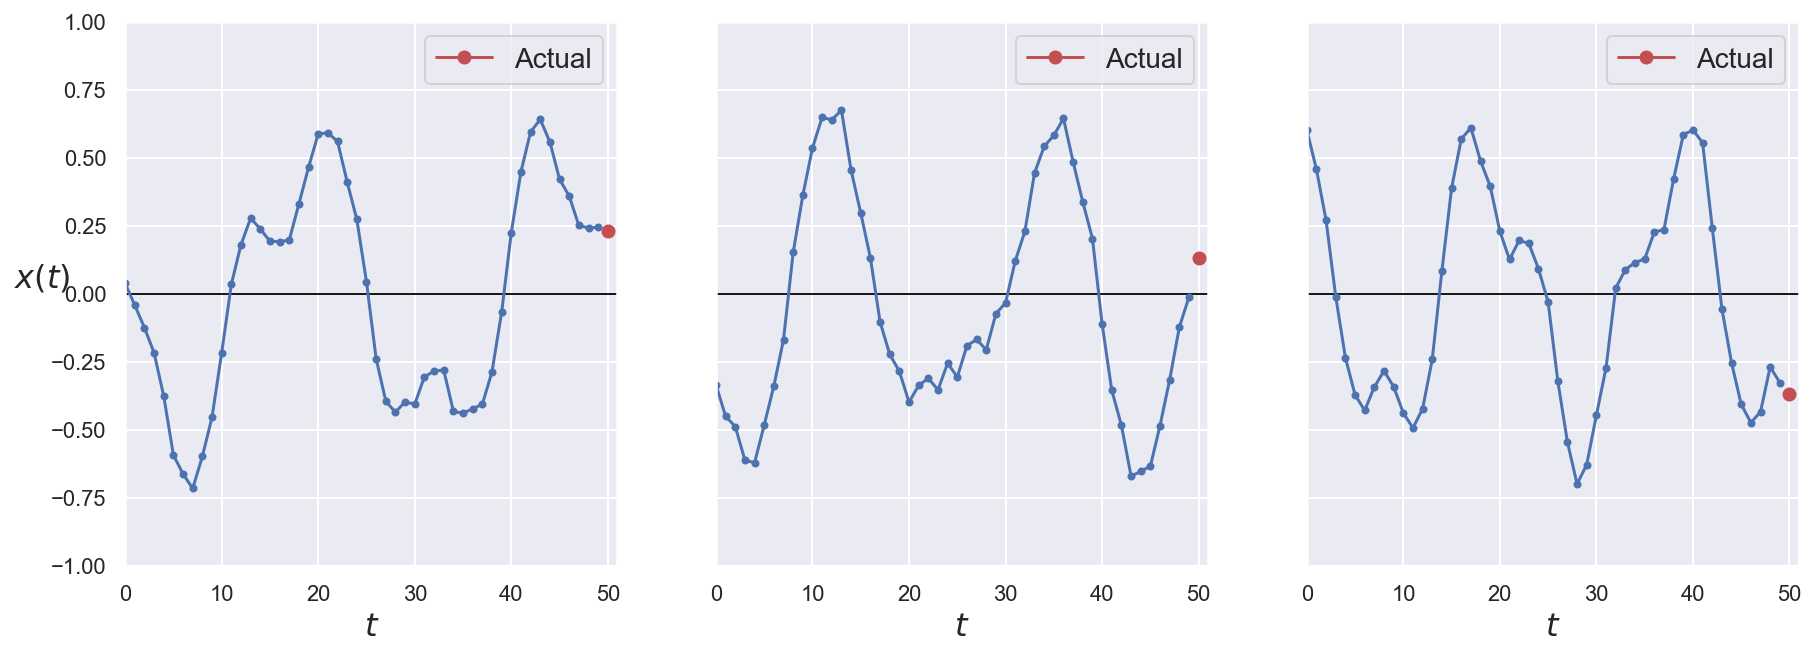

In [6]:
# Plot 3 series from the validation set
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 5))
for col in range(3):
    plt.sca(axes[col])
    plot_series(
        series=x_val[col, :, 0],
        y_true=y_val[col, 0],
        y_label=("$x(t)$" if col == 0 else None),
    )
plt.show()

### Single step, naïve forecasting

Here, we only try to predict the sequence value one step ahead in the future.

A baseline solution (always useful at the beginning of any ML project) would be to use the last know value as prediction.

In [7]:
# Naïve prediction = input for last time step
y_pred_naive = x_val[:, -1]
print(f"y_pred_naive: {y_pred_naive.shape}")

print(f"Naïve predictor MSE: {np.mean(mean_squared_error(y_val, y_pred_naive)):0.05f}")

y_pred_naive: (2000, 1)
Naïve predictor MSE: 0.02044


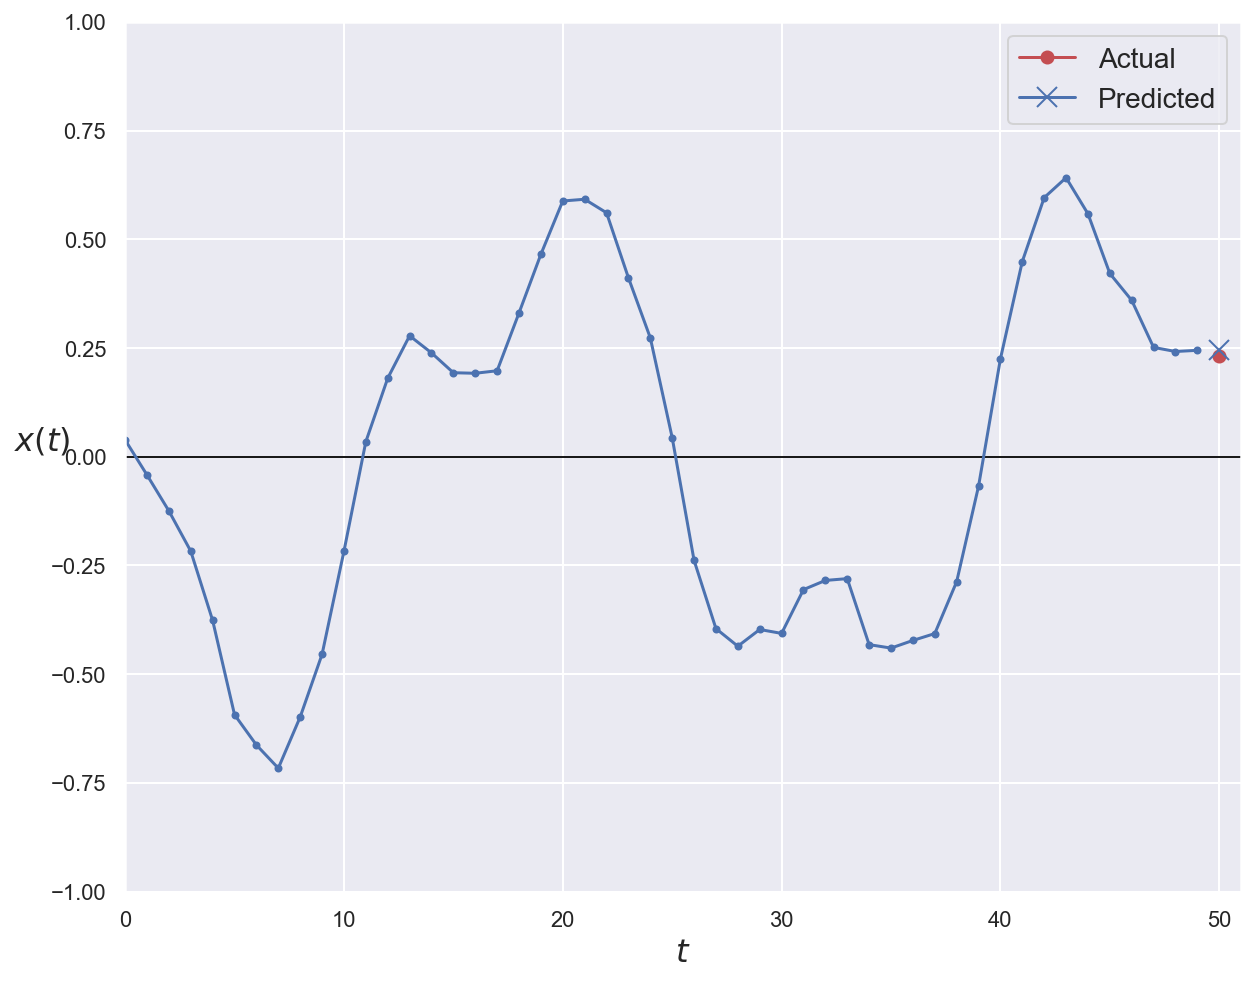

In [8]:
# Plot first validation series with ground truth and prediction
plot_series(series=x_val[0, :, 0], y_true=y_val[0, 0], y_pred=y_pred_naive[0, 0])
plt.show()

### Recurrent neurons

The most basic form of RNN cell is a *recurrent neuron*. It simply sends its output back to itself.

At each time step $t$, it receives the input vector $\mathbf{x}_{(t)}$ and its own scalar output from the previous time step, $y_{(t-1)}$.

[![Recurrent neuron](images/recurrent_neuron.png)](https://github.com/ageron/handson-ml2/)

In [9]:
# Create a linear stack of layers
basic_rnn_model = Sequential()

# Add a RNN layer to the model
# units: dimensionality of the output space (= number of cells inside the layer)
# input_shape: dimensionality of input, excluding batch dimension: vector of shape (time steps, features)
#   Could also be (n_steps, 1) here, but RNN can process any number of time steps, so None is also ok
# This layer expects input as a 3D tensor (batch size, time steps, features)
# Output shape is a 2D tensor (batch size, units) corresponding to the last time step
# Activation function is tanh by default
basic_rnn_model.add(SimpleRNN(units=1, input_shape=(None, 1)))

# 1 weight for input, 1 for recurrent output, 1 for bias = 3 parameters
basic_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


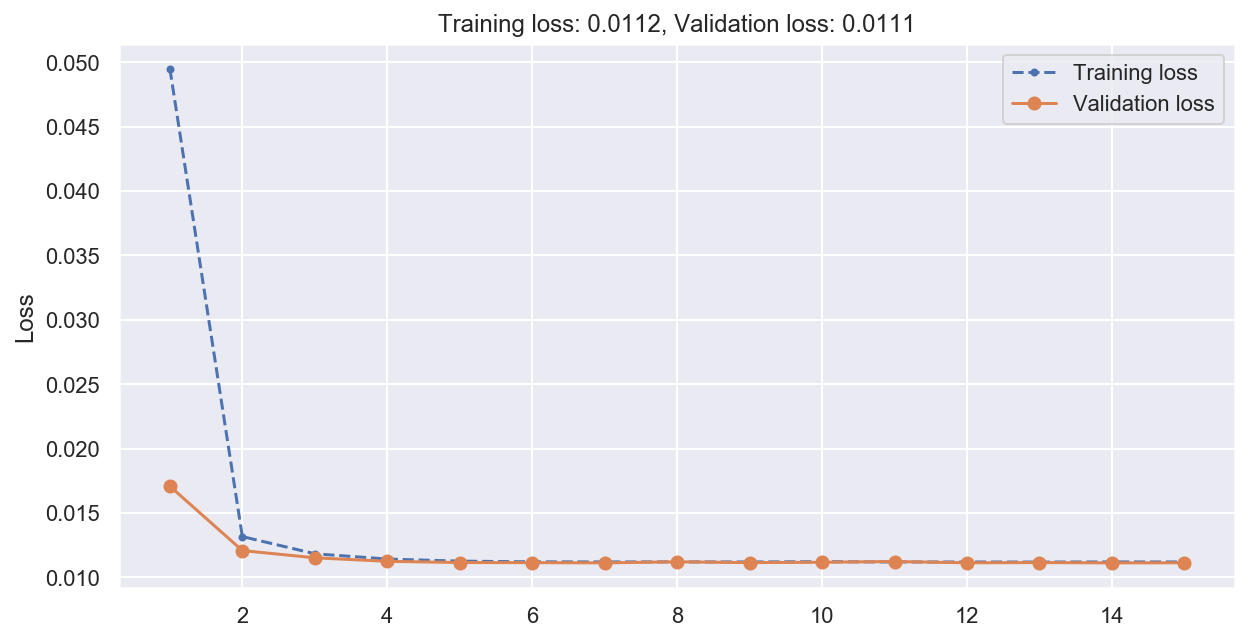

In [10]:
# Compile and train the model

basic_rnn_model.compile(optimizer=Adam(lr=0.005), loss="mse")

history = basic_rnn_model.fit(
    x_train, y_train, epochs=15, verbose=0, validation_data=(x_val, y_val)
)

plot_loss(history)

In [11]:
# Compute predictions and error on validation data

y_pred_basic = basic_rnn_model.predict(x_val)

print(f"Basic RNN MSE: {np.mean(mean_squared_error(y_val, y_pred_basic)):0.05f}")

Basic RNN MSE: 0.01113


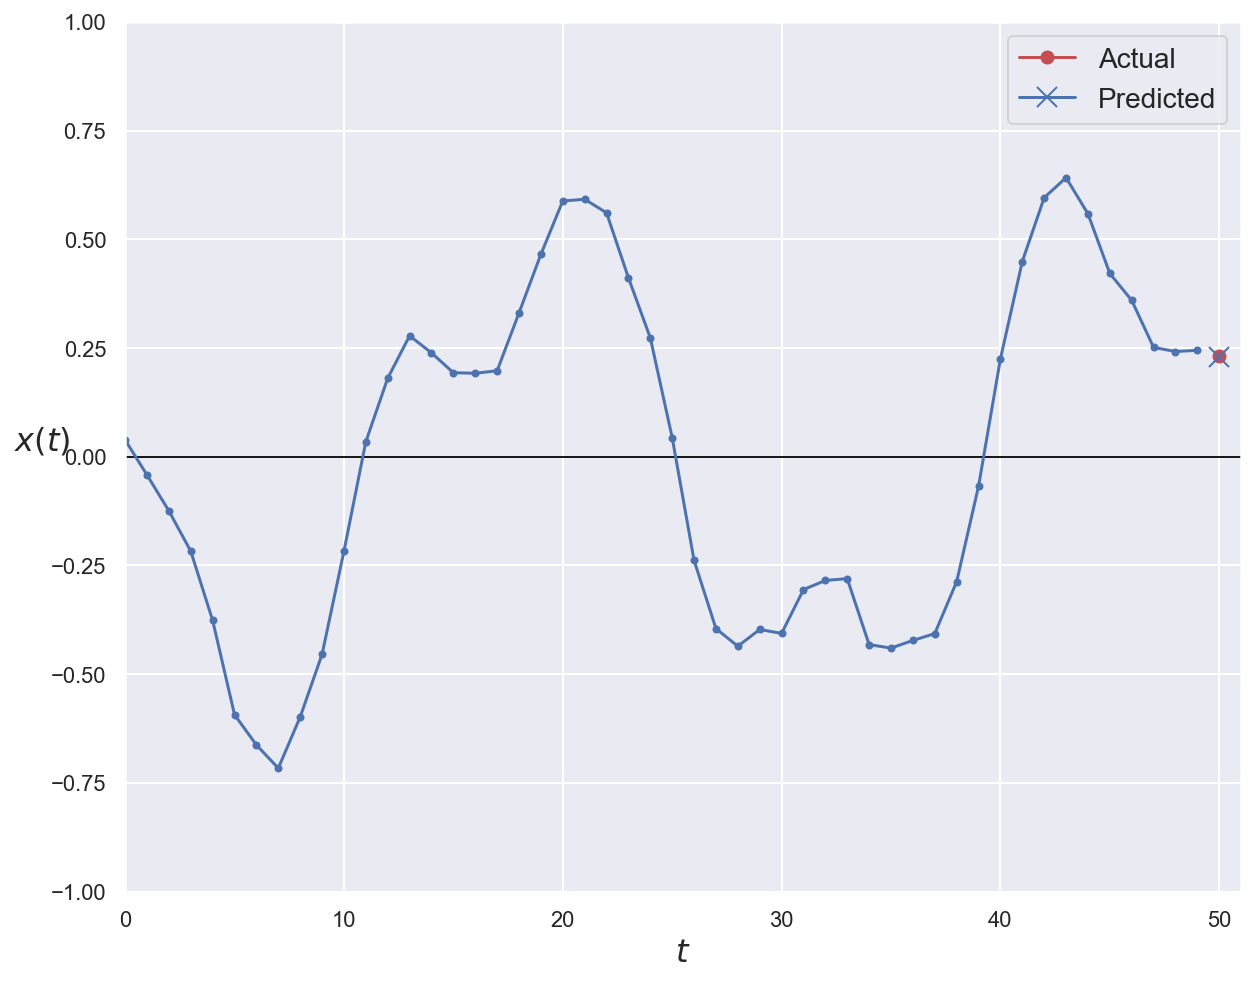

In [12]:
# Plot first validation series with ground truth and prediction
plot_series(series=x_val[0, :, 0], y_true=y_val[0, 0], y_pred=y_pred_basic[0, 0])
plt.show()

### Recurrent layers

Recurrent neurons can be stacked together to form a *recurrent layer*.

At each time step $t$, each neuron of the layer receives both the input vector $\mathbf{x}_{(t)}$ and the output of the layer from the previous time step, $\mathbf{y}_{(t-1)}$ (which is a vector in that case).

![Recurrent layer](images/recurrent_layer.png)

In [13]:
stacked_rnn_model = Sequential()

# return_sequences: if True, the layer outputs the whole sequence instead of the value for last time step
# In that case, output shape is a 3D tensor (batch size, time steps, units)
# This is needed to connect this layer to other recurrent layers
stacked_rnn_model.add(SimpleRNN(units=20, return_sequences=True, input_shape=(None, 1)))

# return_sequences is False by default
# In that case, output shape is a 2D tensor (batch size, units)
# Here, we only care about output for the last time step
stacked_rnn_model.add(SimpleRNN(units=20))

# Add a linear layer to compute the prediction
stacked_rnn_model.add(Dense(units=1))

# First RNN layer: 20 (input) + 20 (bias) + 20x20 (recurrent output) = 440 parameters
# Second RNN layer: 20x20 (input) + 20x20 (recurrent output) + 20 (bias) = 820 parameters
# Dense layer: 20 (input) + 1 (bias) = 21 parameters
stacked_rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


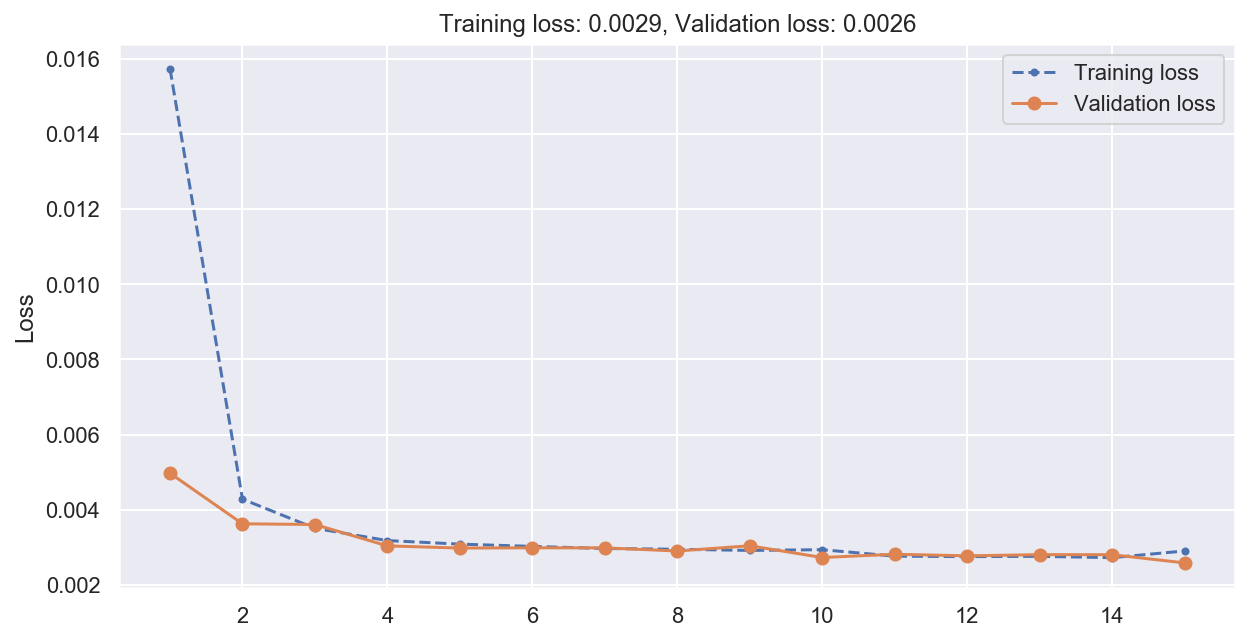

In [14]:
# Compile and train the model

stacked_rnn_model.compile(optimizer="adam", loss="mse")

history = stacked_rnn_model.fit(
    x_train, y_train, epochs=15, verbose=0, validation_data=(x_val, y_val)
)

plot_loss(history)

In [15]:
# Compute predictions and error on validation data

y_pred_stacked = stacked_rnn_model.predict(x_val)

print(f"Stacked RNN MSE: {np.mean(mean_squared_error(y_val, y_pred_stacked)):0.05f}")

Stacked RNN MSE: 0.00259


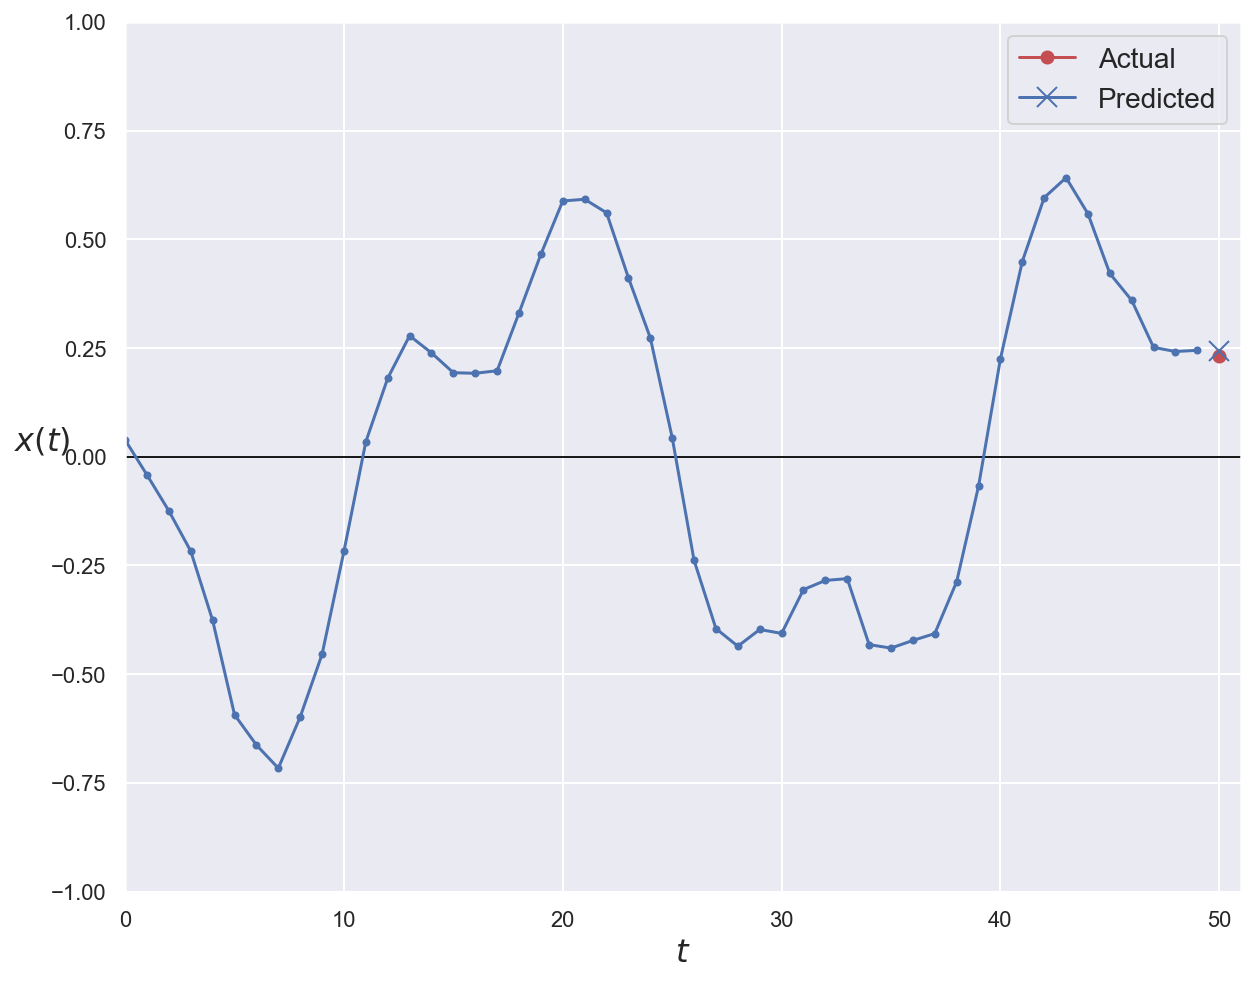

In [16]:
# Plot first validation series with ground truth and prediction
plot_series(series=x_val[0, :, 0], y_true=y_val[0, 0], y_pred=y_pred_stacked[0, 0])
plt.show()

### Multi-step forecasting

To forecast $n$ timesteps ahead, we train the network to predict all $n$ next values at once.

To do so, we need to turn the targets into vectors containing the next $n$ values.

In [17]:
n_steps = 50
# Generate time series of length = n_steps + 10
series = generate_time_series(10000, n_steps + 10)

# Training inputs stay the same
# Targets are now the first (and only) feature for the last 10 time steps
x_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
x_val, y_val = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
x_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

print(f"series: {series.shape}")
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}, y_val: {y_val.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

series: (10000, 60, 1)
x_train: (7000, 50, 1), y_train: (7000, 10)
x_val: (2000, 50, 1), y_val: (2000, 10)
x_test: (1000, 50, 1), y_test: (1000, 10)


In [18]:
multistep_rnn_model = Sequential()

multistep_rnn_model.add(SimpleRNN(units=20, return_sequences=True, input_shape=(None, 1)))
multistep_rnn_model.add(SimpleRNN(units=20))
# Predict 10 steps ahead
multistep_rnn_model.add(Dense(units=10))

multistep_rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


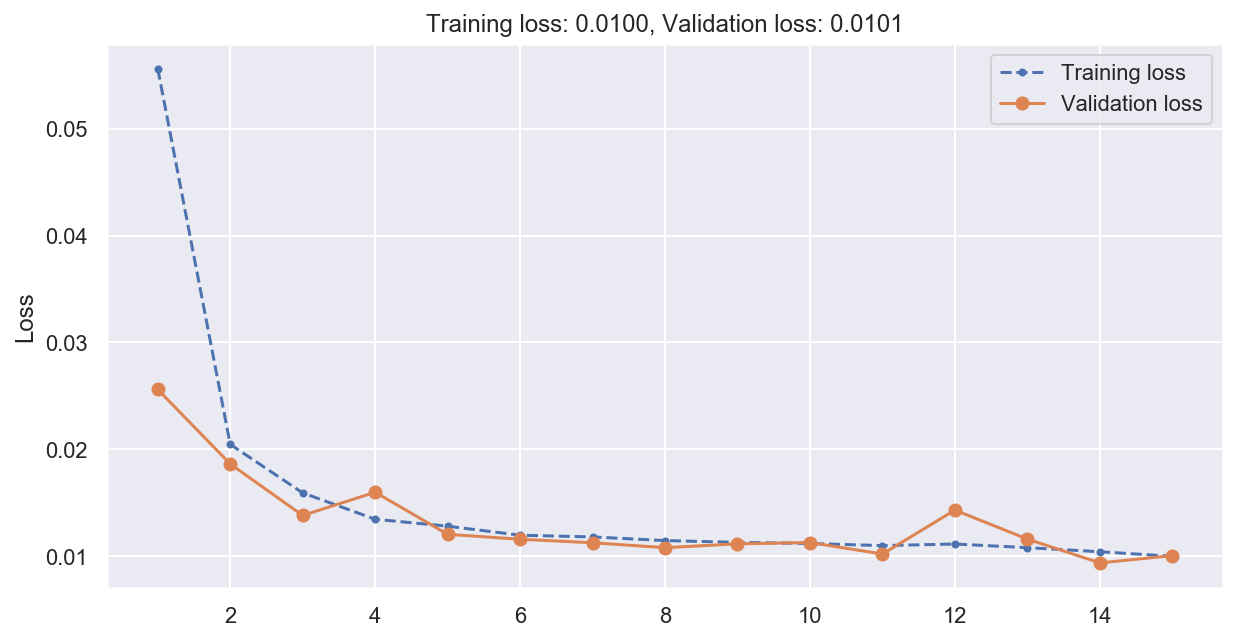

In [19]:
# Compile and train the model

multistep_rnn_model.compile(optimizer="adam", loss="mse")

history = multistep_rnn_model.fit(
    x_train, y_train, epochs=15, verbose=0, validation_data=(x_val, y_val)
)

plot_loss(history)

In [20]:
# Compute predictions and error on validation data

y_pred_multistep = multistep_rnn_model.predict(x_val)

print(f"Multistep RNN MSE: {np.mean(mean_squared_error(y_val, y_pred_multistep)):0.05f}")

Multistep RNN MSE: 0.01007


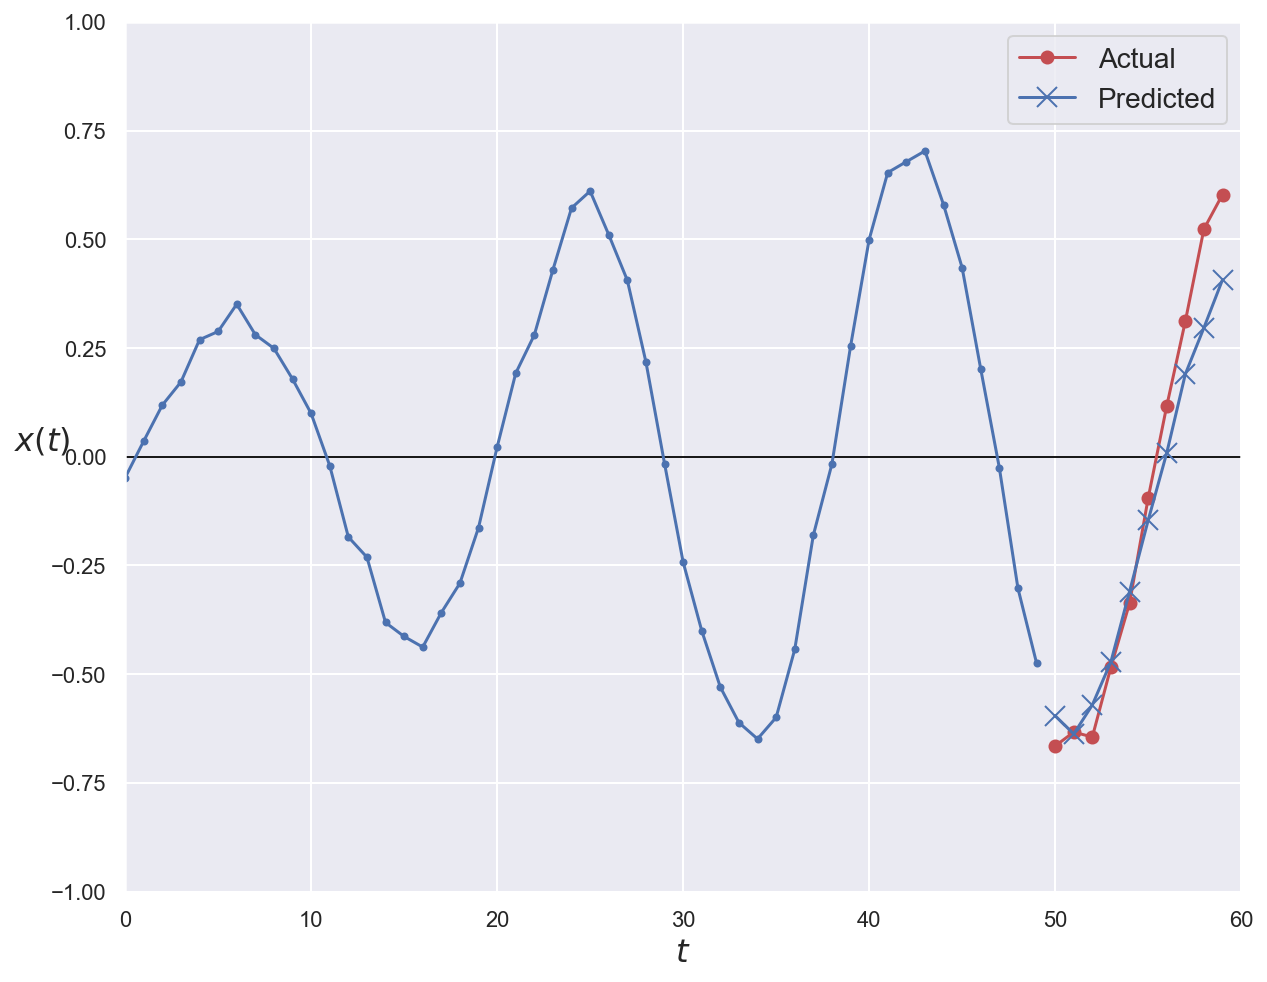

In [21]:
# Plot first validation series with ground truth and prediction
plot_series(
    series=x_val[0, :, 0], y_true=y_val[0], y_pred=y_pred_multistep[0]
)
plt.show()

## LSTM, GRU and 1D convolutions

### The limits of recurrent neurons

Basic RNN architectures suffer from a *short-term memory* problem. Because of data transformations when traversing the layers, some information is lost at each time step. Thus, they struggle to handle long-term dependencies between sequence elements.

Newer, more sophisticated RNN cell types like **LSTM** and **GRU** alleviate this limit.

### LSTM cells

*Long Short-Term Memory* cells are a special kind of RNN cells, capable of learning long-term dependencies in input data. They were introduced in 1997 ([original paper](http://www.bioinf.jku.at/publications/older/2604.pdf)) and have been refined over the years.

An LSTM cell has a complex internal structure that make it able to:
- learn to recognize an important input,
- store it in the long-term state,
- preserve it for as long as it is needed,
- extract it whenever it is needed.

[![LSTM cell](images/lstm_cell.png)](https://github.com/ageron/handson-ml2)

The cell's state is split between $\mathbf{h}_{(t)}$ (*short-term state*) and $\mathbf{c}_{(t)}$ (*long-term state*).

- The layer that outputs $\pmb{g}_{(t)}$ is the main layer. In a basic RNN layer, there would be nothing else.
- The *forget gate* (controlled by $\pmb{f}_{(t)}$) controls which parts of the previous long-term state $\mathbf{c}_{(t-1)}$ should be erased.
- The *input gate* (controlled by $\pmb{i}_{(t)}$) controls which part of the main layer output should ne added to the long-term state.
- The *output gate* (controlled by $\pmb{o}_{(t)}$) controls which parts of the long-term state should be outputted at this time step.

Sigmoid-based layers output values near either 0 (gate closed) or 1 (gate open).

For more details, consult this [step-by-step LSTM walkthrough](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

In [22]:
# Build the simplest possible LSTM model
basic_lstm_model = Sequential()

# The LSTM layer's API is similar to the SimpleRNN's
basic_lstm_model.add(LSTM(units=1, input_shape=(None, 1)))

# 4 weights for input + 4 bias + 4 weights for short-term state = 12 parameters
basic_lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1)                 12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Build a LSTM-based model for time series forcasting
lstm_model = Sequential()

lstm_model.add(LSTM(units=20, return_sequences=True, input_shape=(None, 1)))
lstm_model.add(LSTM(units=20))
# Predict 10 steps ahead
lstm_model.add(Dense(units=10))

# First LSTM layer: 20x4 (input) + 20x4 (bias) + 20x20x4 (short-term state) = 1760
# Second LSTM layer: 20x20x4 (input) + 20x4 (bias) + 20x20x4 (short-term state) = 3280
# Dense layer: 10x20 (input) + 10 (bias) = 210
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 20)          1760      
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________


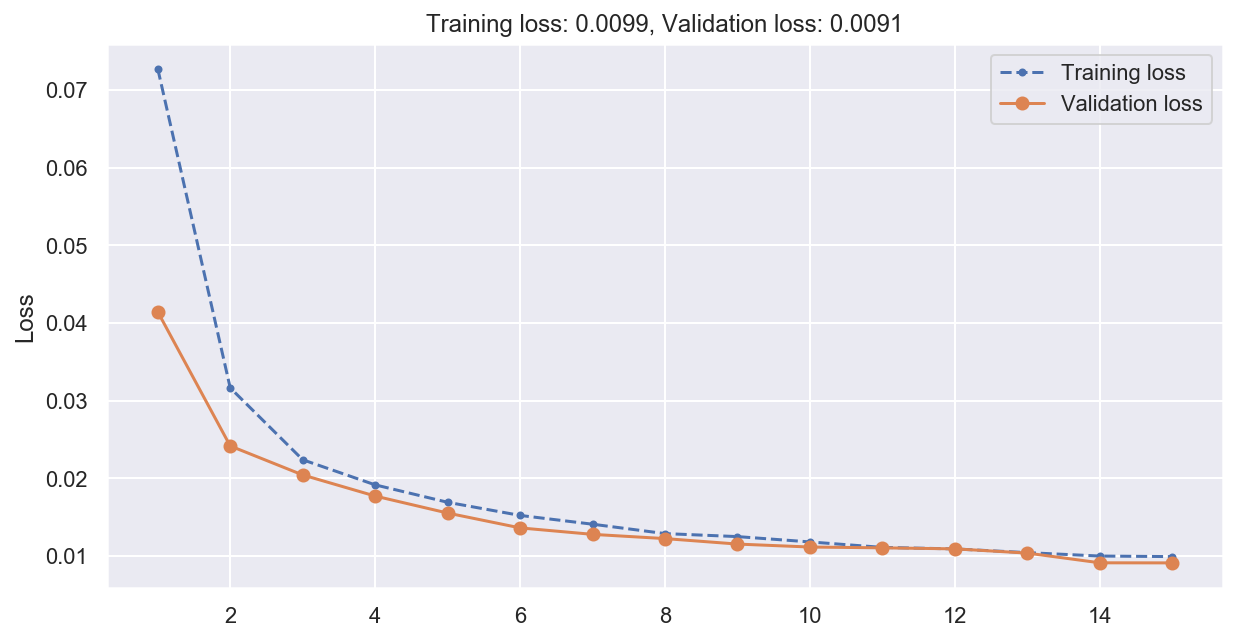

In [24]:
# Compile and train the model

lstm_model.compile(optimizer="adam", loss="mse")

history = lstm_model.fit(
    x_train, y_train, epochs=15, verbose=0, validation_data=(x_val, y_val)
)

plot_loss(history)

In [25]:
# Compute predictions and error on validation data

y_pred_lstm = lstm_model.predict(x_val)

print(f"Multistep RNN MSE: {np.mean(mean_squared_error(y_val, y_pred_lstm)):0.05f}")

Multistep RNN MSE: 0.00911


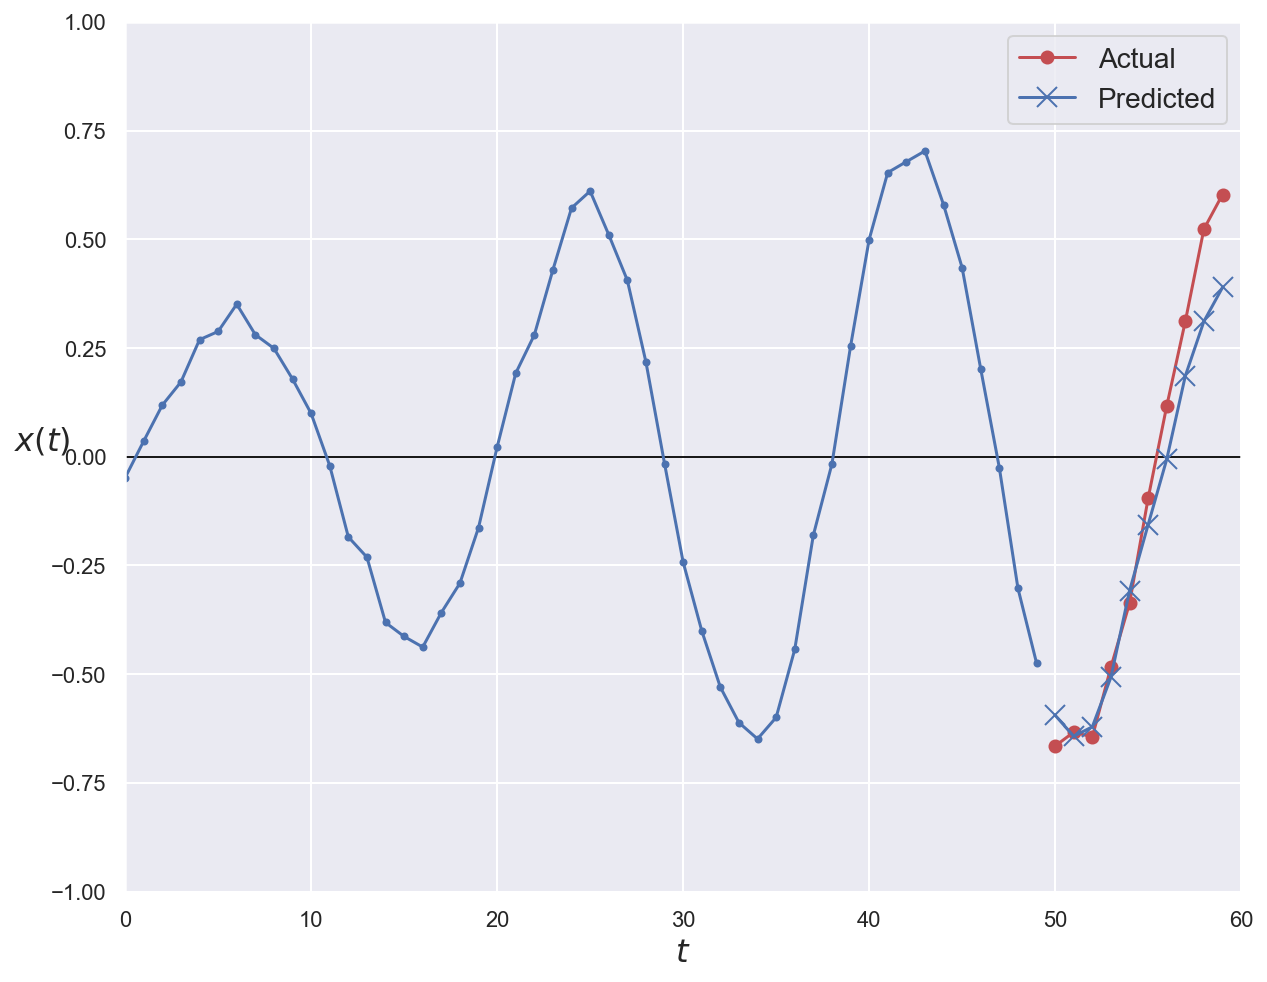

In [26]:
# Plot first validation series with ground truth and prediction
plot_series(
    series=x_val[0, :, 0], y_true=y_val[0], y_pred=y_pred_lstm[0]
)
plt.show()

### GRU cells

The *Gated Recurrent Unit* cell was introduced in 2014 ([original paper](https://arxiv.org/abs/1406.1078)). 

It is a simplification of the LSTM cell that performs similarly well while being faster to train.

[![GRU cell](images/gru_cell.png)](https://github.com/ageron/handson-ml2)

- Short- and long-time states are merged into the $\mathbf{h}_{(t)}$ vector.
- A single update gate controller $\pmb{z}_{(t)}$ manages both the forget and input gates. Whenever one is open, the other is closed.
- There is no output gate. However, the reset gate $\pmb{r}_{(t)}$ controls which part of the previous state is shown to the main layer $\pmb{g}_{(t)}$.

In [27]:
# Build the simplest possible GRU model
basic_gru_model = Sequential()

# The GRU layer's API is similar to the SimpleRNN's
basic_gru_model.add(GRU(units=1, input_shape=(None, 1)))

# Since TF 2.x, Keras separates biases for input and recurrent kernels
# 3 weights for input + 3 input bias + 4 weights for previous state + 4 state bias = 12
basic_gru_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1)                 12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Build a GRU-based model for time series forcasting
gru_model = Sequential()

gru_model.add(GRU(20, return_sequences=True, input_shape=(None, 1)))
gru_model.add(GRU(20))
# Predict 10 steps ahead
gru_model.add(Dense(10))

# First GRU layer: 20x3 (input) + 20x3 (input bias) + 20x20x3 (previous state) + 20x3 (state bias) = 1380
# Second GRU layer: 20x20x3 (input) + 20x3 (input bias) + 20x20x3 (previous state) + 20x3 (state bias) = 2520
# Dense layer: 10x20 (input) + 10 (bias) = 210
gru_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 20)          1380      
_________________________________________________________________
gru_2 (GRU)                  (None, 20)                2520      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
Total params: 4,110
Trainable params: 4,110
Non-trainable params: 0
_________________________________________________________________


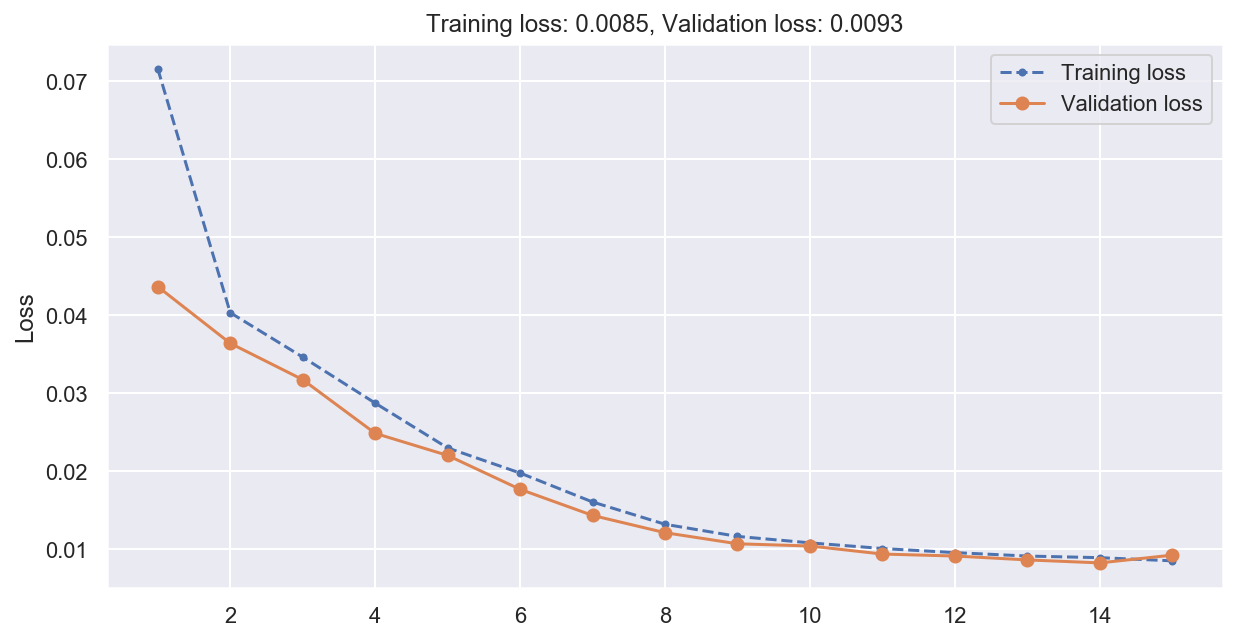

In [29]:
# Compile and train the model

gru_model.compile(optimizer="adam", loss="mse")

history = gru_model.fit(
    x_train, y_train, epochs=15, verbose=0, validation_data=(x_val, y_val)
)

plot_loss(history)

In [30]:
# Compute predictions and error on validation data

y_pred_gru = gru_model.predict(x_val)

print(f"Multistep RNN MSE: {np.mean(mean_squared_error(y_val, y_pred_gru)):0.05f}")

Multistep RNN MSE: 0.00926


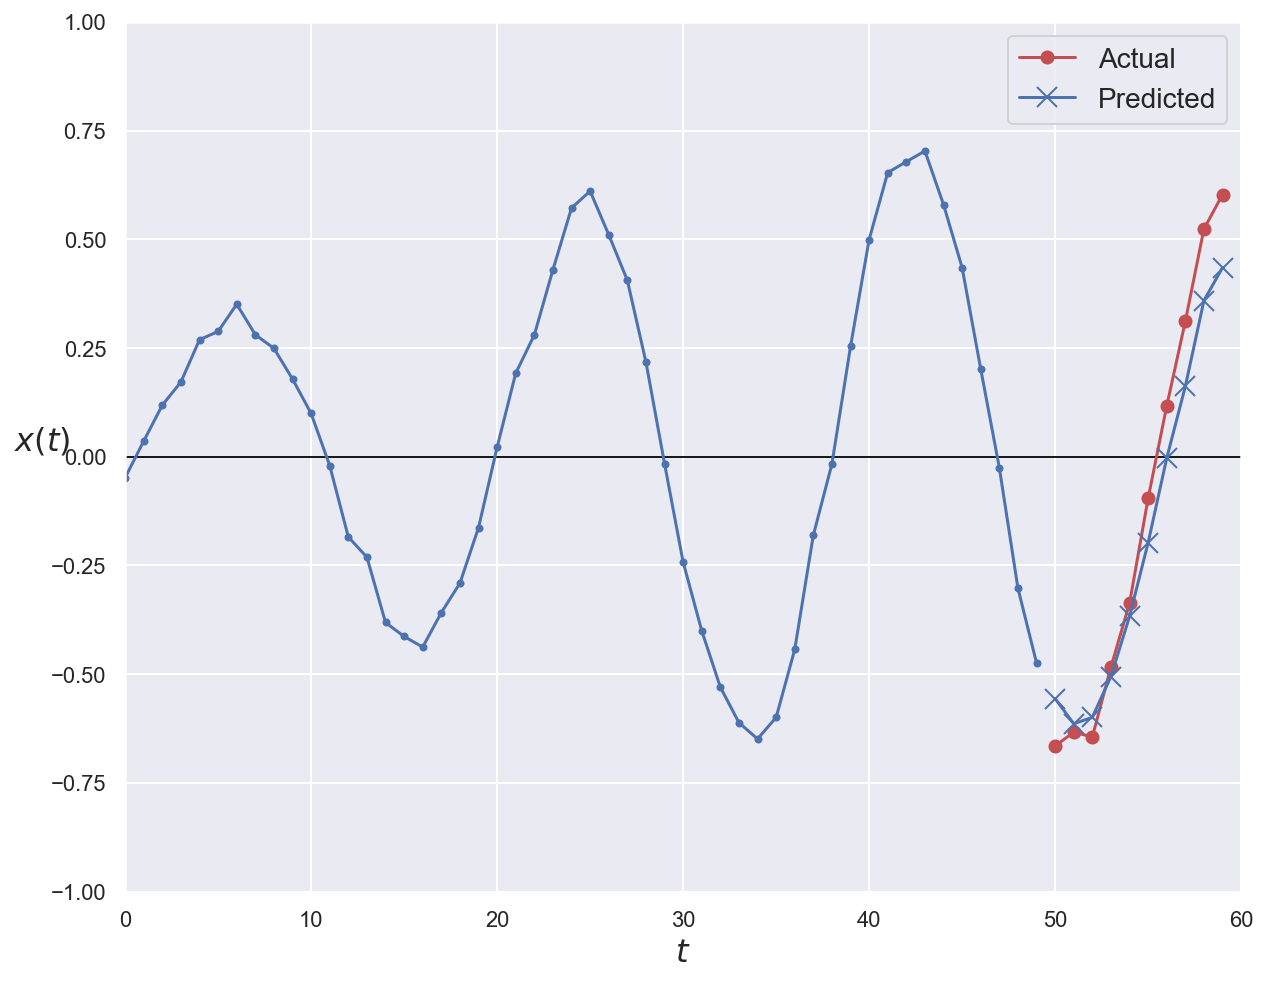

In [31]:
# Plot first validation series with ground truth and prediction
plot_series(
    series=x_val[0, :, 0], y_true=y_val[0], y_pred=y_pred_gru[0]
)
plt.show()

### Sequence processing with 1D convolutions

Despite their many qualities, LSTM and GRU cells still have a fairly limited short-term memory. To facilitate long-pattern detection in sequences of 100 time steps or more, a solution is to shorten the sequences by using **1D convolutions**.

![1D convolution](images/1D_convolution.png)

They work by treating time as a spatial dimension, and sliding several kernels across a sequence. Depending on the kernel size and *stride* (sliding step), the output sequence is typically shorter than the input one. 1D convolution will also detect higher-level features in the sequence, facilitating the work of subsequent layers.

In [32]:
# Create a model combining CNN and RNN operations
conv1d_gru_model = Sequential()

# Add a 1D convolution layer with 20 kernels of size 4
conv1d_gru_model.add(
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid", input_shape=(None, 1))
)
conv1d_gru_model.add(GRU(20, return_sequences=True))
conv1d_gru_model.add(GRU(20))
# Predict 10 steps ahead
conv1d_gru_model.add(Dense(10))

# Conv1D layer: 20x4 (kernels weights) + 20 (kernels bias) = 100
# GRU layers: 20x20x3 (input) + 20x3 (input bias) + 20x20x3 (previous state) + 20x3 (state bias) = 2520
# Dense layer: 10x20 (input) + 10 (bias) = 210
conv1d_gru_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 20)          100       
_________________________________________________________________
gru_3 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
gru_4 (GRU)                  (None, 20)                2520      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
Total params: 5,350
Trainable params: 5,350
Non-trainable params: 0
_________________________________________________________________


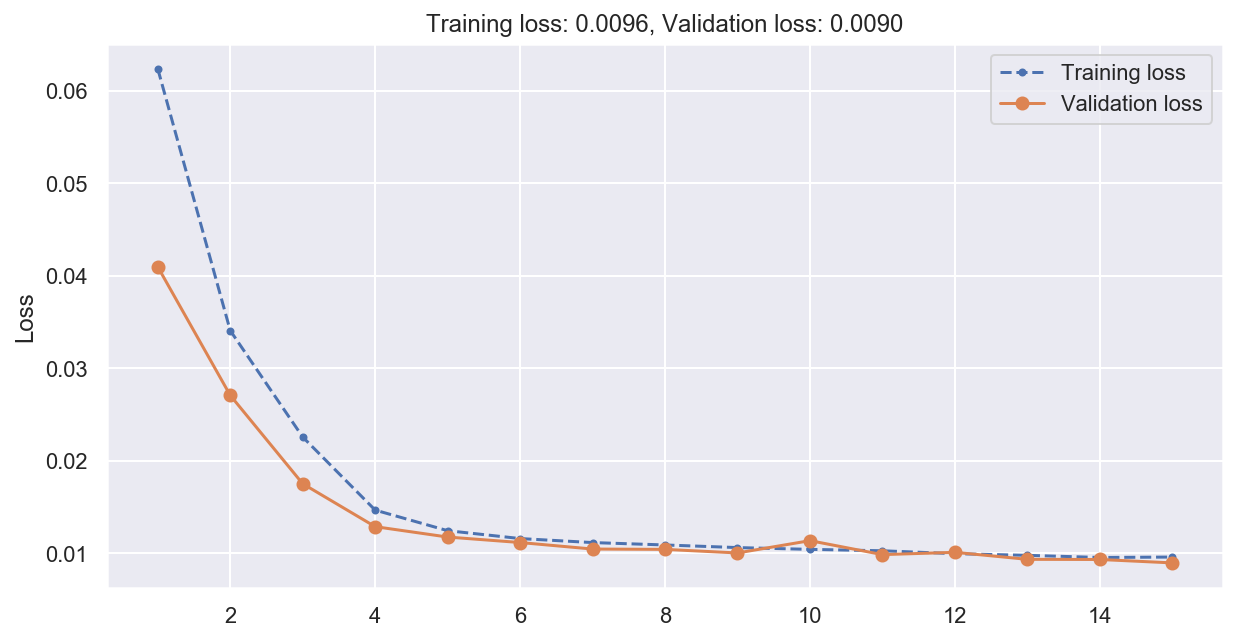

In [33]:
# Compile and train the model

conv1d_gru_model.compile(optimizer="adam", loss="mse")

history = conv1d_gru_model.fit(
    x_train, y_train, epochs=15, verbose=0, validation_data=(x_val, y_val)
)

plot_loss(history)

In [34]:
# Compute predictions and error on validation data

y_pred_conv1d_gru = conv1d_gru_model.predict(x_val)

print(f"Multistep RNN MSE: {np.mean(mean_squared_error(y_val, y_pred_conv1d_gru)):0.05f}")

Multistep RNN MSE: 0.00898


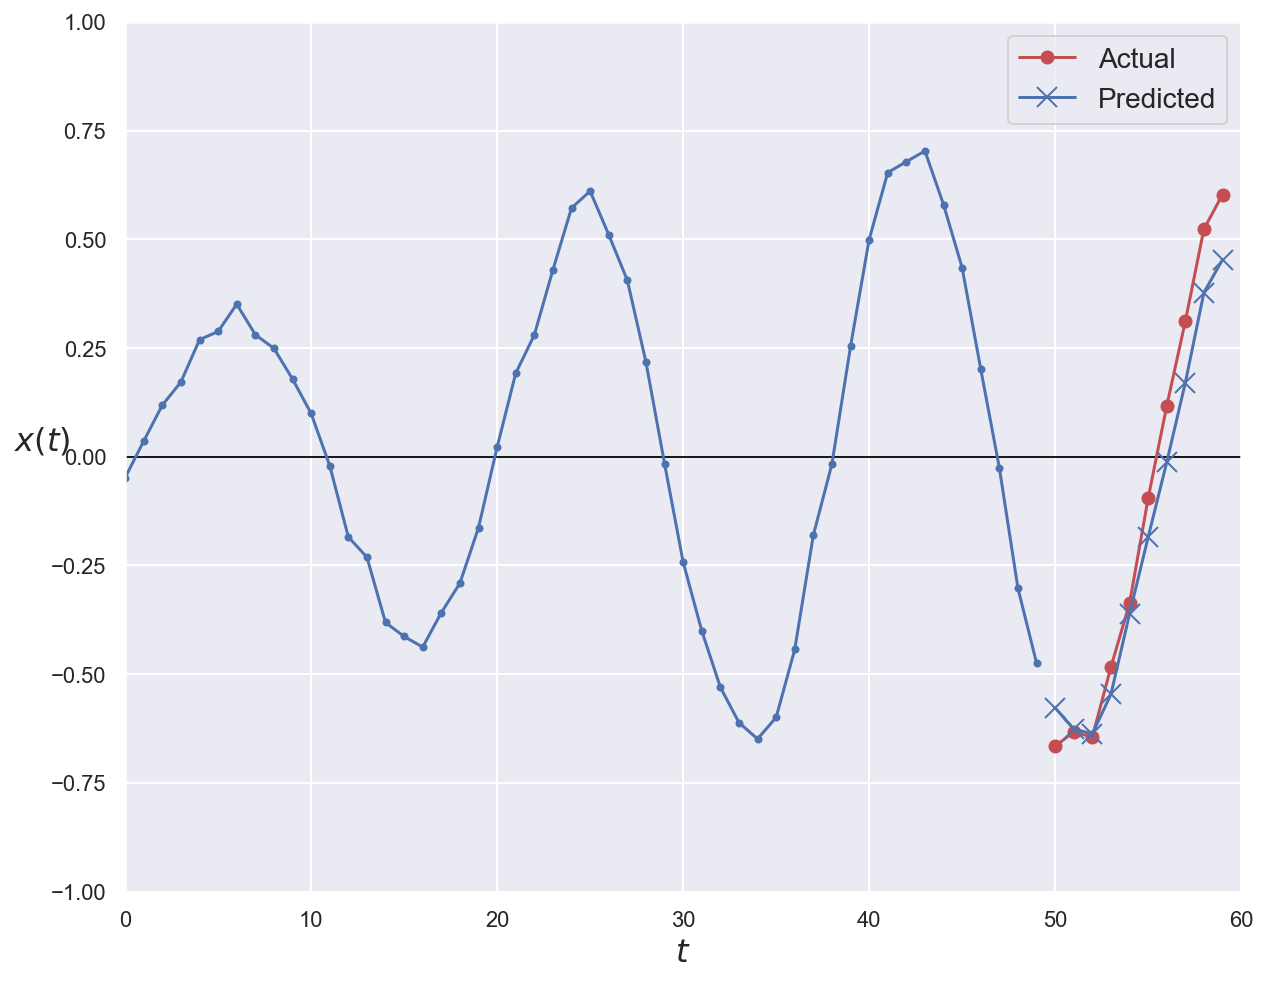

In [35]:
# Plot first validation series with ground truth and prediction
plot_series(
    series=x_val[0, :, 0], y_true=y_val[0], y_pred=y_pred_conv1d_gru[0]
)
plt.show()